# 311 data - Initial Analysis

### References:
- Convert to grayscale: https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python/12201744#12201744
- Keras early stopping: https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
- Grayscale Keras: https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/
- Combining models: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
- Neighborhoods geojson: https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4
- Plotting in folium: https://towardsdatascience.com/visualizing-data-at-the-zip-code-level-with-folium-d07ac983db2



In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import keras
import glob
from PIL import Image

# Import Components for model building
# Import various components for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Import the backend
from keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
% matplotlib inline

In [26]:
# Using the first 60000 data points
# Limited due to computational time and disc space
files = glob.glob('pickles/mini_*pickle.gzde')
dim1, dim2, dim3 = 128, 128, 3

df = pd.concat([pd.read_pickle(fp, compression='gzip') for fp in files])

columns = list(df.columns)
columns = [column.lower().replace(' ', '_') for column in columns]
df.columns = columns

df.dropna(subset=['image'], inplace=True)
df['updated'] = pd.to_datetime(df['updated'])
df['opened'] = pd.to_datetime(df['opened'])
df['closed'] = pd.to_datetime(df['closed'])

X_notflat = np.concatenate(df.image.values.tolist(), axis=0)
X = X_notflat.reshape(df.shape[0], dim1*dim2*dim3)   

In [30]:
X_notflat = X_notflat.reshape(df.shape[0], 128, 128, 3)
X_notflat.shape

(59628, 128, 128, 3)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59628 entries, 33130 to 115928
Data columns (total 21 columns):
caseid                 59628 non-null int64
opened                 59628 non-null datetime64[ns]
closed                 58187 non-null datetime64[ns]
updated                59628 non-null datetime64[ns]
status                 59628 non-null object
status_notes           35636 non-null object
responsible_agency     59628 non-null object
category               59628 non-null object
request_type           59628 non-null object
request_details        58742 non-null object
address                59628 non-null object
street                 58577 non-null object
supervisor_district    59620 non-null float64
neighborhood           59434 non-null object
police_district        59402 non-null object
latitude               59628 non-null float64
longitude              59628 non-null float64
point                  59628 non-null object
source                 59628 non-null object
media

In [95]:
df.head()

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,neighborhood,police_district,latitude,longitude,point,source,media_url,image,group,group2
33130,7548738,2017-08-25 08:19:12,2017-08-25 18:25:22,2017-08-25 18:25:22,Closed,NaN,DPW Ops Queue,Encampments,Encampment Reports,Encampment Cleanup,...,Mission,MISSION,37.768314,-122.414642,"(37.76831436, -122.41464233)",Web,http://mobile311.sfgov.org/reports/7548738/photos,"[[[106, 86, 85], [103, 83, 82], [107, 87, 86],...",Encampments,Encampments
33131,7548737,2017-08-25 08:19:06,2017-08-25 09:44:10,2017-08-25 09:44:10,Closed,Per PSA manager: The drainage from the park w...,RPD Park Service Area 2 Queue,Rec and Park Requests,Park - Neighborhood_Services_Area,Irrigation,...,Alamo Square,NORTHERN,37.776199,-122.436340,"(37.77619934, -122.43634033)",Mobile/Open311,http://mobile311.sfgov.org/reports/7548737/photos,"[[[165, 135, 107], [164, 134, 106], [170, 138,...",Rec and Park Requests,Rec and Park Requests
33132,7548736,2017-08-25 08:18:58,2017-08-25 13:25:21,2017-08-25 13:25:21,Closed,NaN,DPW Ops Queue,Encampments,Encampment Reports,Encampment Cleanup,...,Mission,MISSION,37.760555,-122.415169,"(37.76055527, -122.41516876)",Mobile/Open311,http://mobile311.sfgov.org/reports/7548736/photos,"[[[165, 181, 180], [165, 181, 180], [164, 180,...",Encampments,Encampments
33135,7548724,2017-08-25 08:17:37,2017-08-25 10:10:33,2017-08-25 10:10:33,Closed,NaN,DPW Ops Queue,Encampments,Encampment Reports,Encampment Cleanup,...,Hayes Valley,NORTHERN,37.775936,-122.427116,"(37.77593613, -122.42711639)",Mobile/Open311,http://mobile311.sfgov.org/reports/7548724/photos,"[[[100, 104, 81], [73, 84, 50], [73, 86, 60], ...",Encampments,Encampments
33136,7548722,2017-08-25 08:17:22,2017-08-27 19:15:23,2017-08-27 19:15:23,Closed,NaN,DPW Ops Queue,Illegal Postings,Illegal Postings - Affixed_Improperly,Affixed Improperly,...,Noe Valley,MISSION,37.751389,-122.427429,"(37.75138855, -122.4274292)",Mobile/Open311,http://mobile311.sfgov.org/reports/7548722/photos,"[[[60, 62, 49], [161, 166, 160], [87, 87, 75],...",Signs - Illegal Postings and Repair,Other


In [31]:
# Create a grayscale array
# https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python/12201744#12201744
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

X_gray = rgb2gray(X_notflat)

(59628, 128, 128)


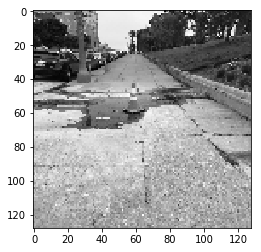

In [35]:
print(X_gray.shape)
plt.imshow(X_gray[1].reshape(128, 128),cmap='gray', vmin=0, vmax=255)

In [38]:
def categorize(df):
    if df['category'] == 'Street and Sidewalk Cleaning':
        if (df['request_type'] == 'Transit_shelter_platform' or
            df['request_type'] == 'Missed_Route_Mechanical_Sweeping'):
            return 'General Cleaning'
        elif df['request_type'] == 'City_garbage_can_overflowing':
            return 'Litter Receptacles'
        elif (df['request_type'] == 'Human Waste' or
              df['request_type'] == 'Medical Waste'):
            return 'Human or Medical Waste'
        elif df['request_type'] == 'Automotive':
            return 'Vehicle'
        else:
            return df['request_type']
    elif ('General' in df['category']) or ('Catch Basin' in df['category']):
        return 'Other'
    elif ((df['category'] == 'Street Defects') or 
          (df['category'] == 'Sidewalk or Curb') or 
          (df['category'] == 'Blocked Street or SideWalk')):
        return 'Street and Sidewalk Issues'
    elif ((df['category'] == 'Abandoned Vehicle') or 
          (df['category'] == 'Parking Enforcement')):
        return 'Vehicle'
    elif (df['category'] == 'Illegal Postings' or
          df['category'] == 'Sign Repair'):
        return 'Signs - Illegal Postings and Repair'
    else:
        return df['category']

In [39]:
df['group'] = df.apply(categorize, axis=1)
print(df['group'].unique())
print(df['group'].nunique())

['Encampments' 'Rec and Park Requests'
 'Signs - Illegal Postings and Repair' 'Litter Receptacles'
 'General Cleaning' 'Street and Sidewalk Issues' 'Human or Medical Waste'
 'Bulky Items' 'Graffiti' 'Hazardous Materials' 'Vehicle' 'Streetlights'
 'Other' 'Damaged Property' 'Sewer Issues' 'Tree Maintenance']
16


In [40]:
df.category.unique()

array(['Encampments', 'Rec and Park Requests', 'Illegal Postings',
       'Street and Sidewalk Cleaning', 'Street Defects', 'Graffiti',
       'Abandoned Vehicle', 'Litter Receptacles', 'Sign Repair',
       'Streetlights', 'General Request - PUBLIC WORKS',
       'Damaged Property', 'Sewer Issues', 'Sidewalk or Curb',
       'Blocked Street or SideWalk', 'Tree Maintenance',
       'Catch Basin Maintenance', 'General Request - MTA',
       'Parking Enforcement', 'General Request - ART COMMISSION',
       'General Request - MUSEUMS', 'General Request - DPH',
       'General Request - BUILDING INSPECTION', 'General Request - PUC',
       'General Request - ANIMAL CARE CONTROL',
       'General Request - PORT AUTHORITY',
       'General Request - FIRE DEPARTMENT', 'General Request - PLANNING'],
      dtype=object)

In [8]:
print(df['category'].unique())
print(df['category'].nunique())

['Encampments' 'Rec and Park Requests' 'Illegal Postings'
 'Street and Sidewalk Cleaning' 'Street Defects' 'Graffiti'
 'Abandoned Vehicle' 'Litter Receptacles' 'Sign Repair' 'Streetlights'
 'General Request - PUBLIC WORKS' 'Damaged Property' 'Sewer Issues'
 'Sidewalk or Curb' 'Blocked Street or SideWalk' 'Tree Maintenance'
 'Catch Basin Maintenance' 'General Request - MTA' 'Parking Enforcement'
 'General Request - ART COMMISSION' 'General Request - MUSEUMS'
 'General Request - DPH' 'General Request - BUILDING INSPECTION'
 'General Request - PUC' 'General Request - ANIMAL CARE CONTROL'
 'General Request - PORT AUTHORITY' 'General Request - FIRE DEPARTMENT'
 'General Request - PLANNING']
28


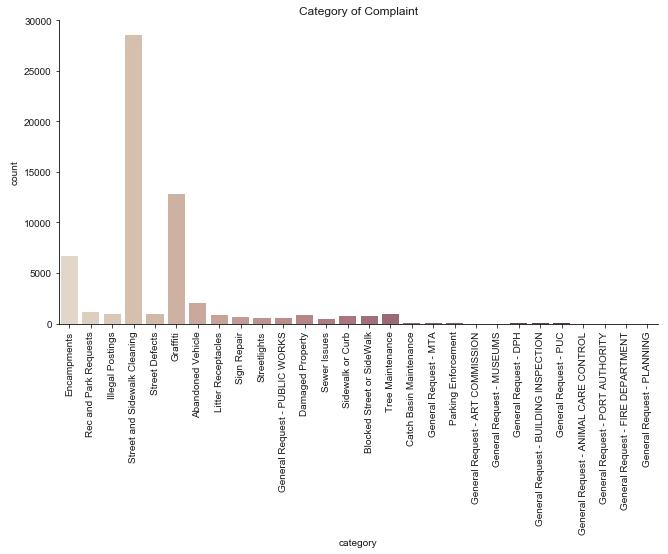

In [9]:
sns.catplot(x='category', 
            kind='count', 
            palette="ch:.25", 
            height=5, 
            aspect=2, 
            data=df)
sns.set(rc={'figure.figsize':(10,20)})
plt.xticks(rotation=90)
plt.title('Category of Complaint')
plt.show()

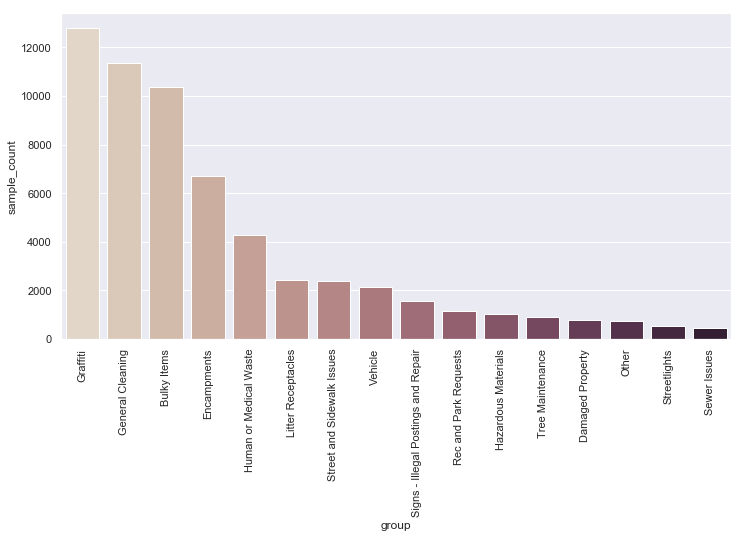

In [10]:
requested = df.groupby('group').count()['caseid'].sort_values(ascending=False).reset_index()
requested.columns = ['group', 'sample_count']

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='group', 
            y='sample_count', 
            palette="ch:.25",
            ax=ax,
            data=requested)
plt.xticks(rotation=90)
plt.show()

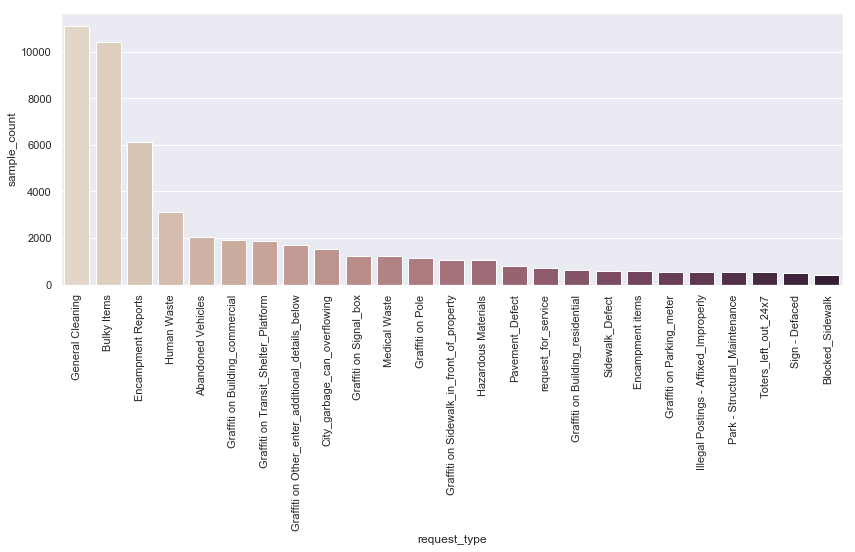

In [77]:
requested = df.groupby('request_type').count()['caseid'].sort_values(ascending=False)[0:25].reset_index()
requested.columns = ['request_type', 'sample_count']
ax = sns.barplot(x='request_type', 
                 y='sample_count', 
                 palette="ch:.25", 
                 data=requested)
plt.xticks(rotation=90)
plt.show()

In [11]:
X.shape

(59628, 49152)

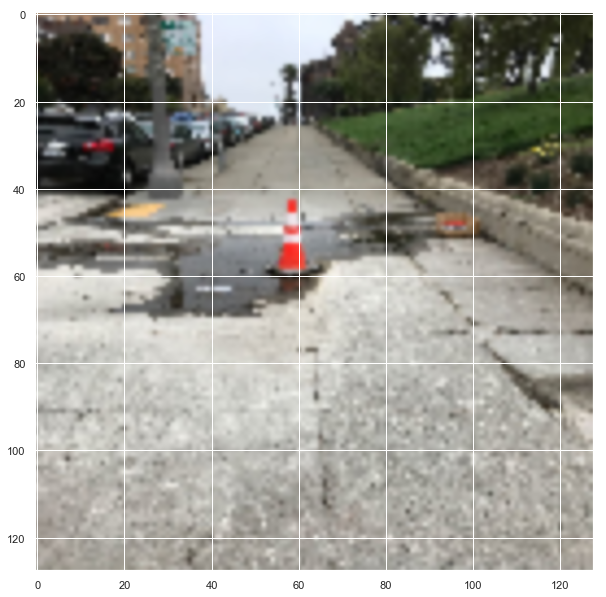

In [12]:
# Used to test viewing images, interpolation needed to help
# keep it from looking so pixelated
plt.imshow(X[1].reshape(128, 128, 3), interpolation='gaussian')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, df['category'], 
                                                    test_size=0.25)

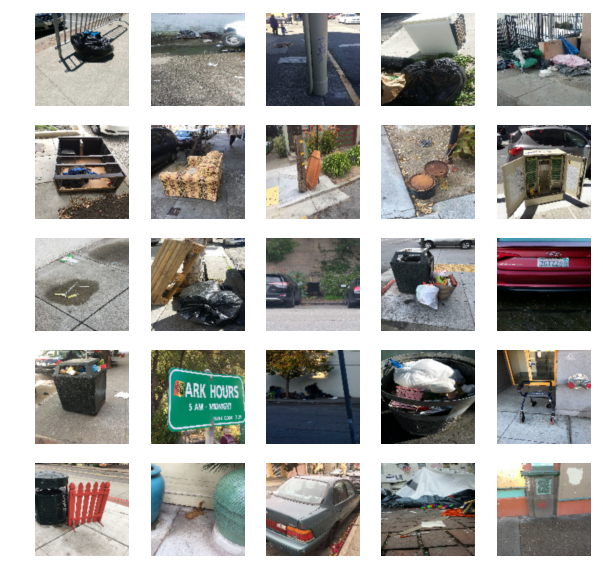

In [14]:
#Examples of dataset
X_train_image = X.reshape(X.shape[0], 128, 128, 3)

#Visualizing dataset
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_train_image)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_train_image[i:i+1][0], 
                           interpolation='gaussian')

# Multi-Layer Perceptron


In [287]:
# Convert to float32 for type consistency
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize values to 1 from 0 to 255 (256 values of pixels)
X_train /= 255
X_test /= 255

# Print sample sizes
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices
# instead of one column with 10 values, create 29 binary columns
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

y_train = keras.utils.to_categorical(y_train_enc, 29)
y_test = keras.utils.to_categorical(y_test_enc, 29)

44721 train samples
14907 test samples


In [290]:
# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the
# first layer
# Relu is the activation function
model.add(Dense(64, activation='relu', input_shape=(49152,)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have
model.add(Dense(29, activation='softmax'))

model.summary()

# Compile the model to put it all together
model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                3145792   
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 29)                1885      
Total params: 3,151,837
Trainable params: 3,151,837
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 44721 samples, validate on 14907 samples
Epoch 1/20
44721/44721 [==========

Not amazing considering half are street or sidewalk cleaning

In [16]:
X_train, X_test, y_group_train, y_group_test = train_test_split(X, df['group'], test_size=0.25)

# Convert to float32 for type consistency
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize values to 1 from 0 to 255 (256 values of pixels)
X_train /= 255
X_test /= 255

# Print sample sizes
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

44721 train samples
14907 test samples


In [18]:
# Convert class vectors to binary class matrices
# instead of one column with 10 values, create 29 binary columns
le = LabelEncoder()
y_train_enc = le.fit_transform(y_group_train)
y_test_enc = le.transform(y_group_test)

y_train = keras.utils.to_categorical(y_train_enc, 16)
y_test = keras.utils.to_categorical(y_test_enc, 16)

# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the
# first layer
# Relu is the activation function
model.add(Dense(64, activation='relu', input_shape=(49152,)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have
model.add(Dense(16, activation='softmax'))

model.summary()

# Compile the model to put it all together
model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                3145792   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
Total params: 3,150,992
Trainable params: 3,150,992
Non-trainable params: 0
___________

# Convolutional Neural Network

In [20]:
# Done with groups
# input image dimensions, from our data
img_rows, img_cols = 128, 128
num_classes = 16

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

# Building the Model
model = Sequential()
# First convolutional layer, note the specification of shape
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 44721 samples, validate on 14907 samples
Epoch 1/5
44721/44721 [==============================] - 12094s 270ms/step - loss: 2.3843 - acc: 0.2233 - val_loss: 2.2406 - val_acc: 0.2228
Epoch 2/5
44721/44721 [==============================] - 11511s 257ms/step - loss: 2.1398 - acc: 0.2974 - val_loss: 2.0403 - val_acc: 0.3229
Epoch 3/5
44721/44721 [==============================] - 11595s 259ms/step - loss: 2.0155 - acc: 0.3394 - val_loss: 2.0111 - val_acc: 0.3493
Epoch 4/5
44721/44721 [==============================] - 14387s 322ms/step - loss: 1.8928 - acc: 0.3784 - val_loss: 1.9608 - val_acc: 0.3702
Epoch 5/5
44721/44721 [==============================] - 14415s 322ms/step - loss: 1.7475 - acc: 0.4241 - val_loss: 2.1655 - val_acc: 0.3211
Test loss: 2.1655195694202596
Test accuracy: 0.3211243039962551


# Black and white

In [67]:
le_group = LabelEncoder()
y_group = le_group.fit_transform(df['group'])

X_train_g, X_test_g, y_train_enc, y_test_enc = train_test_split(X_gray[0:5000], 
                                                                y_group[0:5000], 
                                                                test_size=0.25)

y_train = keras.utils.to_categorical(y_train_enc, 16)
y_test = keras.utils.to_categorical(y_test_enc, 16)

# Convert to float32 for type consistency
X_train_g = X_train_g.astype('float32')
X_test_g = X_test_g.astype('float32')

# Normalize values to 1 from 0 to 255 (256 values of pixels)
X_train_g /= 255
X_test_g /= 255

img_rows, img_cols = 128, 128
input_shape = (img_rows, img_cols, 1)

X_train_g = X_train_g.reshape(X_train_g.shape[0], img_rows, img_cols, 1)
X_test_g = X_test_g.reshape(X_test_g.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
num_classes = 16

print('x_train shape:', X_train_g.shape)
print(X_train_g.shape[0], 'train samples')
print(X_test_g.shape[0], 'test samples')

x_train shape: (3750, 128, 128, 1)
3750 train samples
1250 test samples


In [70]:
# Building the Model
model = Sequential()
# First convolutional layer, note the specification of shape
model.add(Conv2D(128, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Set callback functions to early stop training and save 
# the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = model.fit(X_train_g, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=(X_test_g, y_test))
score = model.evaluate(X_test_g, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Train on 3750 samples, validate on 1250 samples
Epoch 1/10
3750/3750 [==============================] - 1430s 381ms/step - loss: 2.8672 - acc: 0.2099 - val_loss: 2.3288 - val_acc: 0.2688
Epoch 2/10
3750/3750 [==============================] - 3706s 988ms/step - loss: 2.4393 - acc: 0.2357 - val_loss: 2.3361 - val_acc: 0.2632
Epoch 3/10
3750/3750 [==============================] - 3793s 1s/step - loss: 2.3895 - acc: 0.2464 - val_loss: 2.2925 - val_acc: 0.2640
Epoch 4/10
3750/3750 [==============================] - 2129s 568ms/step - loss: 2.3326 - acc: 0.2696 - val_loss: 2.2933 - val_acc: 0.2696
Epoch 5/10
3750/3750 [==============================] - 1399s 373ms/step - loss: 2.3109 - acc: 0.2699 - val_loss: 2.2983 - val_acc: 0.2432
Test loss: 2.2982722093582155
Test accuracy: 0.2432


In [72]:
y_pred = model.predict(X_test_g)  
#y_pred_labels = np.argmax(y_pred, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

#confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)  

In [74]:
y_pred.shape

(1250, 16)

In [79]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_conf = np.argmax(y_test, axis=1)
confusion_matrix = confusion_matrix(y_true=y_test_conf, y_pred=y_pred_labels)  

In [80]:
print(confusion_matrix)

[[ 10   0  24  70  24   0   0   0   0   0   0   0   7   0   0   0]
 [  1   0   4   2   4   0   0   0   0   1   0   0   0   0   0   0]
 [ 14   0  44  45  23   0   0   0   0   3   0   0   1   0   0   0]
 [ 11   0  23  83  24   0   0   0   0   1   0   0   9   0   0   0]
 [ 23   0  26 128 127   0   0   0   0   0   0   0  32   0   0   0]
 [  0   0   0   3   3   0   0   0   0   0   0   0   1   0   0   0]
 [  2   0  11  38  13   0   0   0   0   2   0   0  23   0   0   0]
 [  5   0   3  15   3   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   5   3   0   0   0   0   2   0   0   1   0   0   0]
 [ 10   0   9  26  14   0   0   0   0   7   0   0   5   0   0   0]
 [  1   0   3   8   7   0   0   0   0   1   0   0   4   0   0   0]
 [  3   0   8  21  25   0   0   0   0   1   0   0   0   0   0   0]
 [  7   0   5  47  23   0   0   0   0   1   0   0  33   0   0   0]
 [  2   0   0   1   8   0   0   0   0   3   0   0   0   0   0   0]
 [  1   0  12  19   5   0   0   0   0   0   0   0   0   0   0 

In [84]:
print(le_group.inverse_transform(range(0, 16)))
print(le_group.inverse_transform([1, 5, 6, 7, 8, 10, 11, 13, 14, 15]))
print('classified as:')
print(le_group.inverse_transform([0, 2, 3, 4, 9, 12]))

['Bulky Items' 'Damaged Property' 'Encampments' 'General Cleaning'
 'Graffiti' 'Hazardous Materials' 'Human or Medical Waste'
 'Litter Receptacles' 'Other' 'Rec and Park Requests' 'Sewer Issues'
 'Signs - Illegal Postings and Repair' 'Street and Sidewalk Issues'
 'Streetlights' 'Tree Maintenance' 'Vehicle']
['Damaged Property' 'Hazardous Materials' 'Human or Medical Waste'
 'Litter Receptacles' 'Other' 'Sewer Issues'
 'Signs - Illegal Postings and Repair' 'Streetlights' 'Tree Maintenance'
 'Vehicle']
classified as:
['Bulky Items' 'Encampments' 'General Cleaning' 'Graffiti'
 'Rec and Park Requests' 'Street and Sidewalk Issues']


No predictions for the following: 'Damaged Property' 'Hazardous Materials' 'Human or Medical Waste'
 'Litter Receptacles' 'Other' 'Sewer Issues'
 'Signs - Illegal Postings and Repair' 'Streetlights' 'Tree Maintenance'
 'Vehicle']

Text(33,0.5,'Actual')

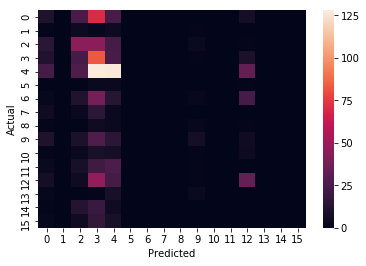

In [86]:
sns.heatmap(confusion_matrix)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [87]:
new_others = list(le_group.inverse_transform([1, 5, 6, 7, 8, 10, 11, 13, 14, 15]))

In [88]:
new_others

['Damaged Property',
 'Hazardous Materials',
 'Human or Medical Waste',
 'Litter Receptacles',
 'Other',
 'Sewer Issues',
 'Signs - Illegal Postings and Repair',
 'Streetlights',
 'Tree Maintenance',
 'Vehicle']

In [91]:
df['group2'] = df['group']
df['group2'] = df['group2'].replace(to_replace=new_others, value='Other')
print(df['group2'].nunique())

7


In [92]:
df.head()

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,neighborhood,police_district,latitude,longitude,point,source,media_url,image,group,group2
33130,7548738,2017-08-25 08:19:12,2017-08-25 18:25:22,2017-08-25 18:25:22,Closed,NaN,DPW Ops Queue,Encampments,Encampment Reports,Encampment Cleanup,...,Mission,MISSION,37.768314,-122.414642,"(37.76831436, -122.41464233)",Web,http://mobile311.sfgov.org/reports/7548738/photos,"[[[106, 86, 85], [103, 83, 82], [107, 87, 86],...",Encampments,Encampments
33131,7548737,2017-08-25 08:19:06,2017-08-25 09:44:10,2017-08-25 09:44:10,Closed,Per PSA manager: The drainage from the park w...,RPD Park Service Area 2 Queue,Rec and Park Requests,Park - Neighborhood_Services_Area,Irrigation,...,Alamo Square,NORTHERN,37.776199,-122.436340,"(37.77619934, -122.43634033)",Mobile/Open311,http://mobile311.sfgov.org/reports/7548737/photos,"[[[165, 135, 107], [164, 134, 106], [170, 138,...",Rec and Park Requests,Rec and Park Requests
33132,7548736,2017-08-25 08:18:58,2017-08-25 13:25:21,2017-08-25 13:25:21,Closed,NaN,DPW Ops Queue,Encampments,Encampment Reports,Encampment Cleanup,...,Mission,MISSION,37.760555,-122.415169,"(37.76055527, -122.41516876)",Mobile/Open311,http://mobile311.sfgov.org/reports/7548736/photos,"[[[165, 181, 180], [165, 181, 180], [164, 180,...",Encampments,Encampments
33135,7548724,2017-08-25 08:17:37,2017-08-25 10:10:33,2017-08-25 10:10:33,Closed,NaN,DPW Ops Queue,Encampments,Encampment Reports,Encampment Cleanup,...,Hayes Valley,NORTHERN,37.775936,-122.427116,"(37.77593613, -122.42711639)",Mobile/Open311,http://mobile311.sfgov.org/reports/7548724/photos,"[[[100, 104, 81], [73, 84, 50], [73, 86, 60], ...",Encampments,Encampments
33136,7548722,2017-08-25 08:17:22,2017-08-27 19:15:23,2017-08-27 19:15:23,Closed,NaN,DPW Ops Queue,Illegal Postings,Illegal Postings - Affixed_Improperly,Affixed Improperly,...,Noe Valley,MISSION,37.751389,-122.427429,"(37.75138855, -122.4274292)",Mobile/Open311,http://mobile311.sfgov.org/reports/7548722/photos,"[[[60, 62, 49], [161, 166, 160], [87, 87, 75],...",Signs - Illegal Postings and Repair,Other


# With 7 groups

In [93]:
le_group2 = LabelEncoder()
y_group2 = le_group2.fit_transform(df['group2'])

X_train_g, X_test_g, y_train_enc2, y_test_enc2 = train_test_split(X_gray[0:5000], 
                                                                  y_group2[0:5000], 
                                                                  test_size=0.25)

y_train2 = keras.utils.to_categorical(y_train_enc2, 7)
y_test2 = keras.utils.to_categorical(y_test_enc2, 7)

# Convert to float32 for type consistency
X_train_g = X_train_g.astype('float32')
X_test_g = X_test_g.astype('float32')

# Normalize values to 1 from 0 to 255 (256 values of pixels)
X_train_g /= 255
X_test_g /= 255

img_rows, img_cols = 128, 128
input_shape = (img_rows, img_cols, 1)

X_train_g = X_train_g.reshape(X_train_g.shape[0], img_rows, img_cols, 1)
X_test_g = X_test_g.reshape(X_test_g.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
num_classes = 7

print('x_train shape:', X_train_g.shape)
print(X_train_g.shape[0], 'train samples')
print(X_test_g.shape[0], 'test samples')

x_train shape: (3750, 128, 128, 1)
3750 train samples
1250 test samples


In [94]:
# Building the Model
model = Sequential()
# First convolutional layer, note the specification of shape
model.add(Conv2D(128, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Set callback functions to early stop training and save 
# the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model_7.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = model.fit(X_train_g, y_train2,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=(X_test_g, y_test2))
score = model.evaluate(X_test_g, y_test2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 3750 samples, validate on 1250 samples
Epoch 1/10
3750/3750 [==============================] - 1489s 397ms/step - loss: 2.3504 - acc: 0.2363 - val_loss: 1.8720 - val_acc: 0.2512
Epoch 2/10
3750/3750 [==============================] - 1473s 393ms/step - loss: 1.9313 - acc: 0.2800 - val_loss: 1.8548 - val_acc: 0.3016
Epoch 3/10
3750/3750 [==============================] - 1491s 397ms/step - loss: 1.8230 - acc: 0.2901 - val_loss: 1.7800 - val_acc: 0.3032
Epoch 4/10
3750/3750 [==============================] - 1344s 359ms/step - loss: 1.7989 - acc: 0.3056 - val_loss: 1.7911 - val_acc: 0.2944
Epoch 5/10
3750/3750 [==============================] - 1347s 359ms/step - loss: 1.7690 - acc: 0.3184 - val_loss: 1.7999 - val_acc: 0.3072
Test loss: 1.7999384212493896
Test accuracy: 0.3072
